In [2]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential,load_model
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt


In [18]:

def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
SIZE = 160
color_img = []
path = '..\dataset\landscape Images\color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files): 
        if i == '6000.jpg':
                break
        else: 
                img = cv2.imread(path + '/'+i,1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (SIZE, SIZE))
                img = img.astype('float32') / 255.0
                color_img.append(img_to_array(img))


gray_img = []
path = '..\dataset\landscape Images\gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
        if i == '6000.jpg':
                break
        else: 
                img = cv2.imread(path + '/'+i,1)
                img = cv2.resize(img, (SIZE, SIZE))
                img = img.astype('float32') / 255.0
                gray_img.append(img_to_array(img))
         

  0%|          | 0/11273 [00:00<?, ?it/s]

 53%|█████▎    | 6000/11273 [00:04<00:03, 1406.04it/s]


In [19]:
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)  
    plt.show()

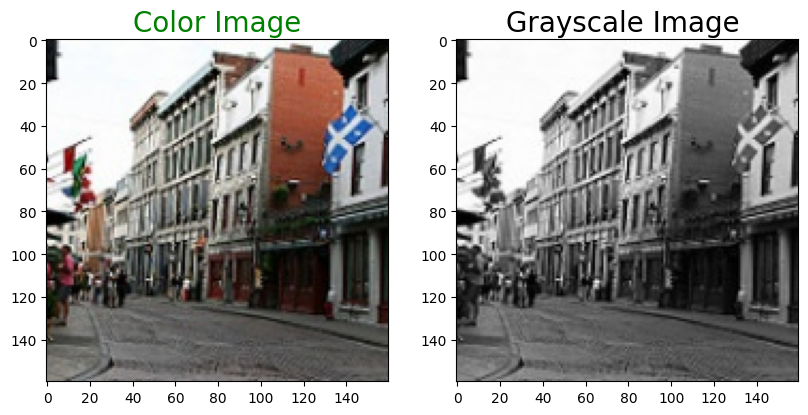

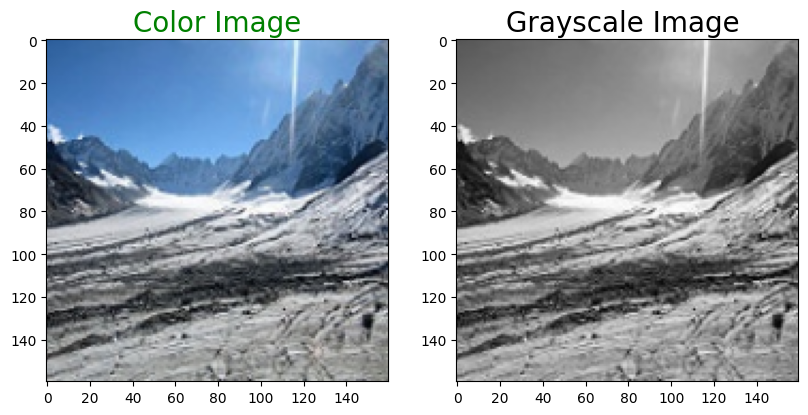

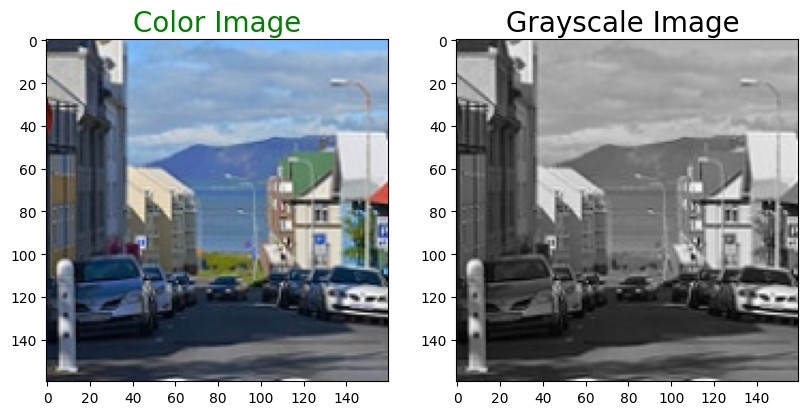

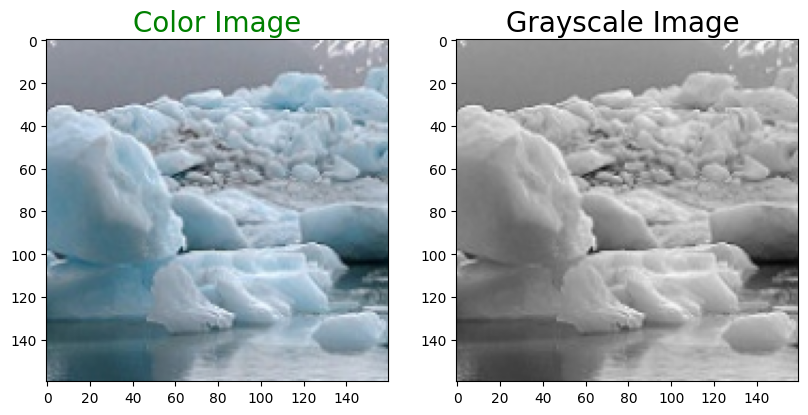

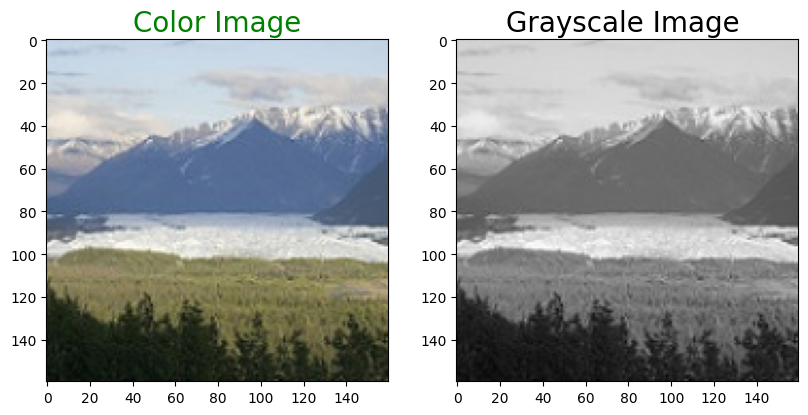

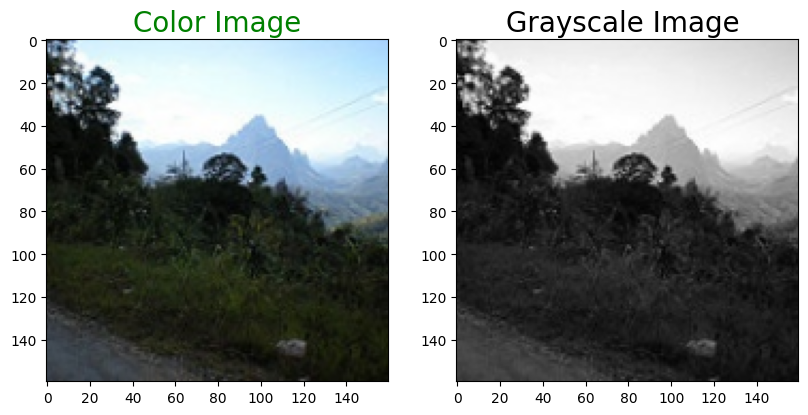

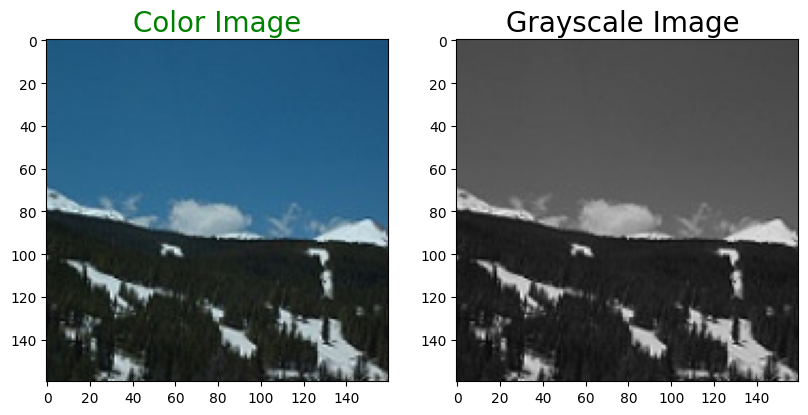

In [20]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

In [21]:
train_gray_image = gray_img[:5500]
train_color_image = color_img[:5500]

test_gray_image = gray_img[5500:]
test_color_image = color_img[5500:]

train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5500, 160, 160, 3)
Test color image shape (500, 160, 160, 3)


In [23]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [24]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [26]:
model = model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 sequential_10 (Sequential)  (None, 80, 80, 128)          3584      ['input_2[0][0]']             
                                                                                                  
 sequential_11 (Sequential)  (None, 40, 40, 128)          147584    ['sequential_10[0][0]']       
                                                                                                  
 sequential_12 (Sequential)  (None, 20, 20, 256)          296192    ['sequential_11[0][0]']       
                                                                                            

In [27]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                        loss = 'mean_absolute_error', metrics = ['acc'])
history = model.fit(train_g, train_c, batch_size=32, epochs=50,
                        validation_data=(test_gray_image,test_color_image))

Epoch 1/50
172/172 [==============================] - 86s 489ms/step - loss: 0.0762 - acc: 0.4257 - val_loss: 0.0706 - val_acc: 0.2928
Epoch 2/50
172/172 [==============================] - 84s 490ms/step - loss: 0.0554 - acc: 0.4676 - val_loss: 0.0612 - val_acc: 0.3861
Epoch 3/50
172/172 [==============================] - 84s 488ms/step - loss: 0.0511 - acc: 0.4838 - val_loss: 0.0610 - val_acc: 0.3335
Epoch 4/50
172/172 [==============================] - 82s 479ms/step - loss: 0.0488 - acc: 0.4960 - val_loss: 0.0515 - val_acc: 0.4756
Epoch 5/50
172/172 [==============================] - 83s 485ms/step - loss: 0.0479 - acc: 0.5029 - val_loss: 0.0489 - val_acc: 0.5220
Epoch 6/50
172/172 [==============================] - 84s 489ms/step - loss: 0.0469 - acc: 0.5164 - val_loss: 0.0494 - val_acc: 0.5096
Epoch 7/50
172/172 [==============================] - 83s 480ms/step - loss: 0.0460 - acc: 0.5290 - val_loss: 0.0503 - val_acc: 0.4926
Epoch 8/50
172/172 [==============================] - 8

In [32]:
model.save('my_model.h5')

In [28]:
results = model.evaluate(test_gray_image,test_color_image)
print('Test loss: {:4f}'.format(results[0]))
print('Test accuracy: {:4f}'.format(results[1]))

16/16 [==============================] - 2s 142ms/step - loss: 0.0479 - acc: 0.5579
Test loss: 0.047945
Test accuracy: 0.557903


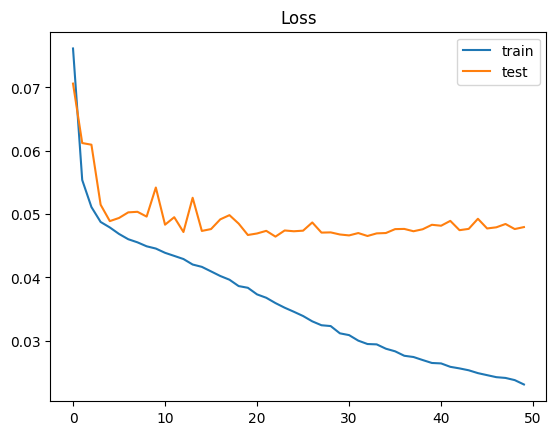

In [29]:

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()




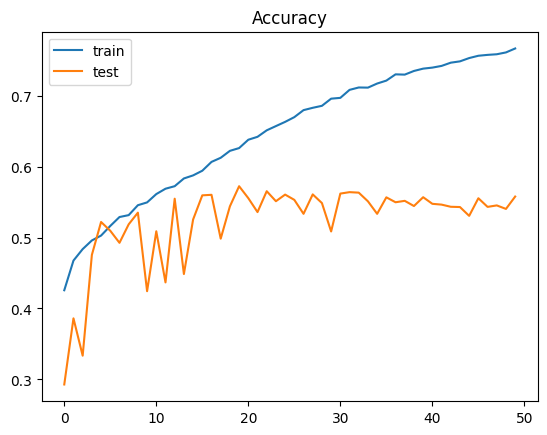

In [30]:

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

1/1 [==============================] - 0s 141ms/step


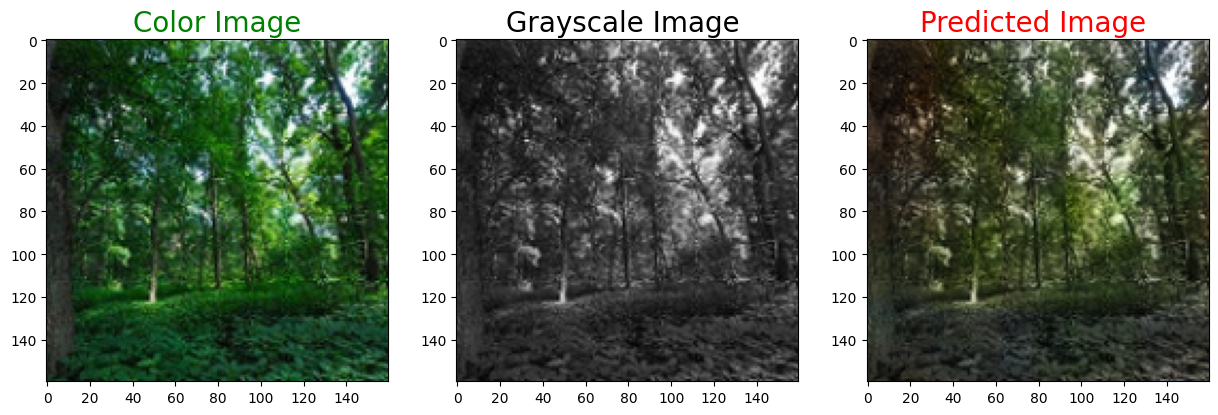

1/1 [==============================] - 0s 38ms/step


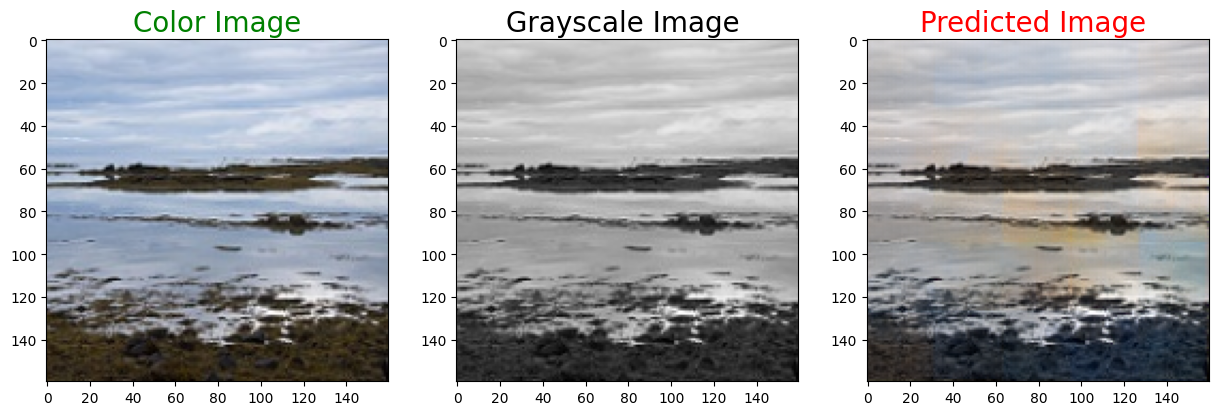

1/1 [==============================] - 0s 27ms/step


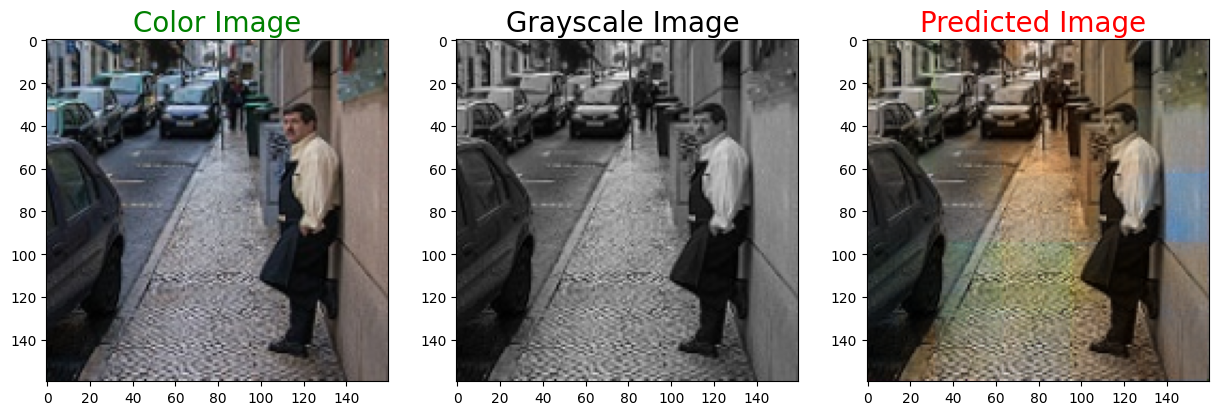

1/1 [==============================] - 0s 36ms/step


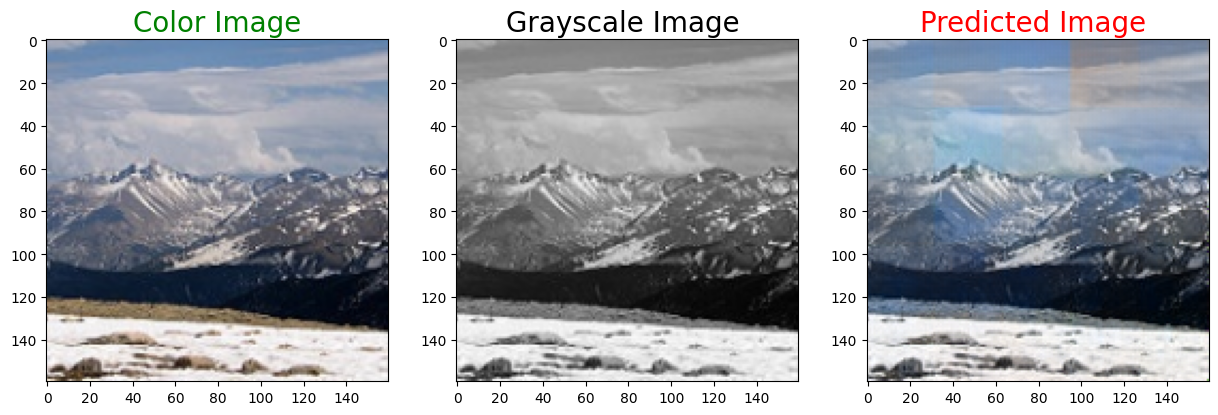

1/1 [==============================] - 0s 40ms/step


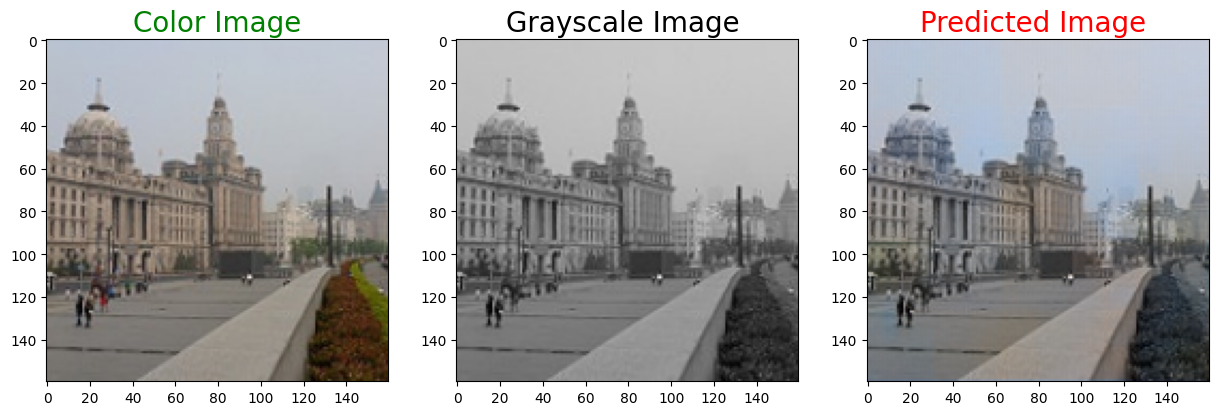

1/1 [==============================] - 0s 28ms/step


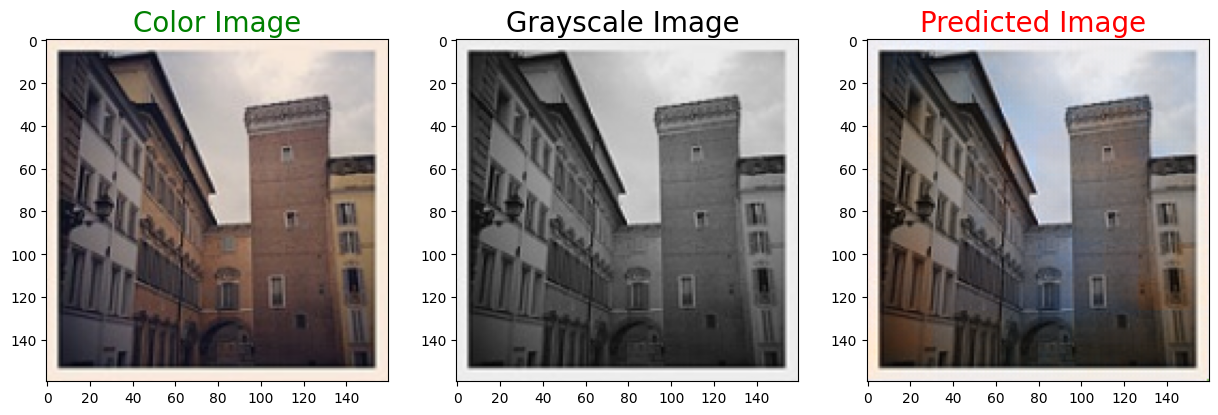

1/1 [==============================] - 0s 28ms/step


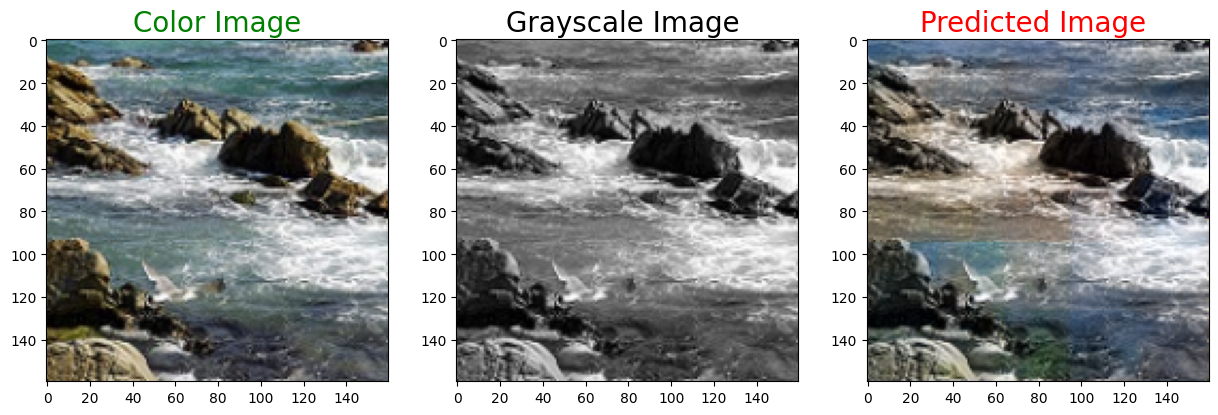

1/1 [==============================] - 0s 25ms/step


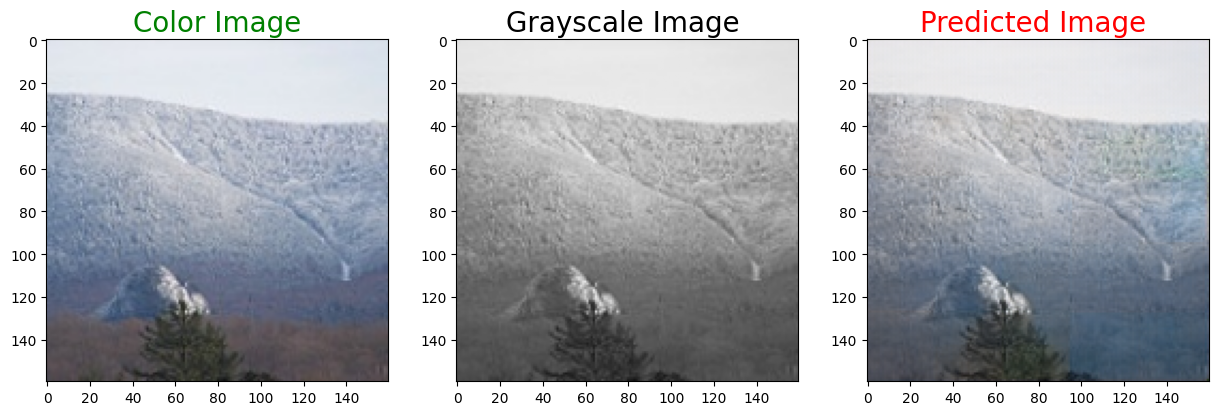

1/1 [==============================] - 0s 31ms/step


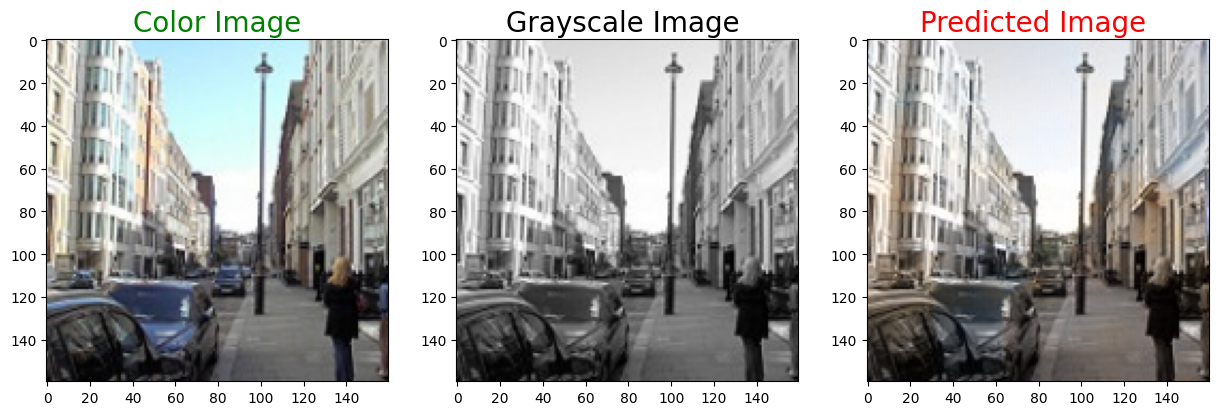

In [31]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(1,10):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)